In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')


display(movies.head())
display(tags.head())
display(ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.head()

/tmp/ipykernel_31825/3744492305.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Filter the movies df
movies = movies[movies.movieId.isin(ratings.movieId.unique().tolist())]
movies.shape

(9724, 3)

### Feature Engineering


In [8]:
### Feature Engineering



In [9]:
# Merge
merged = pd.merge(movies, tags, on='movieId', how='left')
# Drop useless columns.
merged.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09


In [10]:
# Create a new DataFrame merged_df with a new metadata column from tags and genres.
merged.fillna("", inplace=True)
merged = pd.DataFrame(merged.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
merged_df = pd.merge(movies, merged, on='movieId', how='left')
merged_df['metadata'] = merged_df[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)

merged_df.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy


In [11]:
### Create a content latent matrix from metadata


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(merged_df['metadata'])
count_df = pd.DataFrame(count_matrix.toarray(), index=merged_df.index.tolist())
count_df.head()

/home/proctor/.pyenv/versions/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
count_df.shape

(9724, 1675)

In [14]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD
svd = TruncatedSVD(n_components=25)
latent_df = svd.fit_transform(count_df)

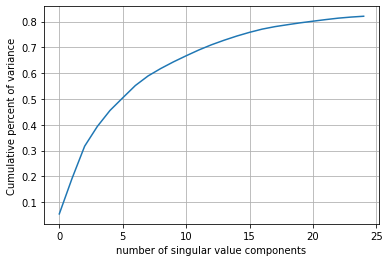

In [15]:
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [16]:
# keep the first 25 number of latent components.
n = 25 
latent_df = pd.DataFrame(latent_df[:,0:n], index=merged_df.title.tolist())
latent_df.shape

(9724, 25)

In [17]:
### Create a latent matrix from user ratings

In [18]:
# Merge
ratings1 = pd.merge(movies[['movieId']], ratings, on="movieId", how="right")
# Pivot
ratings2 = ratings1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
display(ratings2.head())
ratings2.shape

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


(9724, 610)

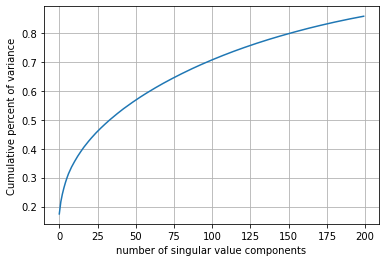

In [19]:
svd = TruncatedSVD(n_components=200)
latent_df_2 = svd.fit_transform(ratings2)
 
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [20]:
latent_df_2 = pd.DataFrame(latent_df_2, index=merged_df.title.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),37.649828,-6.380094,14.994617,0.286947,-1.887147,4.790050,8.807630,-2.198637,1.153305,1.387561,...,0.771149,2.775911,0.078897,0.137784,-2.333257,1.881046,0.797501,0.208083,0.423269,1.342669
Jumanji (1995),20.596193,-0.477880,10.865916,-8.635795,-3.072411,-0.517149,4.359215,-3.821408,-3.394116,0.236474,...,0.780127,-1.104396,-1.107607,0.041806,0.753819,-2.565680,-0.606938,-1.669092,0.139222,1.837846
Grumpier Old Men (1995),8.504182,-5.714924,3.441693,-6.382810,0.024162,-0.783433,-1.423027,-0.542292,3.270655,1.897236,...,-0.532603,-0.590376,-0.300632,-0.104968,1.031713,-0.457403,0.936592,0.862620,0.527280,-0.452945
Waiting to Exhale (1995),0.465720,-0.828101,0.954583,-0.239080,-0.735695,-0.877414,0.214720,-0.527368,0.079467,0.015617,...,-0.240792,0.087172,0.129508,-0.078625,-0.134482,0.137241,-0.311287,-0.603986,0.036307,-0.132424
Father of the Bride Part II (1995),6.071045,-2.673536,4.698195,-4.415807,-3.714221,-1.673627,1.297653,-1.308023,1.325734,1.229592,...,-0.209226,0.340655,0.291949,0.139166,0.679595,-0.561024,-0.600501,1.067206,-0.080992,-0.467733


In [21]:
latent_df_2.shape


(9724, 200)

In [22]:
### Apply cosine similarity in content and colaborative matrices


In [23]:
movies.loc[movies['title'].str.contains("interste", case=False)] 

,movieId,title,genres
8376,109487,Interstellar (2014),Sci-Fi IMAX


In [24]:
merged_df.loc[merged_df['title'].str.contains("roboco", case=False)] 

,movieId,title,genres,tag,metadata
454,519,RoboCop 3 (1993),Action Crime Drama Sci-Fi Thriller,,Action Crime Drama Sci-Fi Thriller
2246,2985,RoboCop (1987),Action Crime Drama Sci-Fi Thriller,,Action Crime Drama Sci-Fi Thriller
2247,2986,RoboCop 2 (1990),Action Crime Sci-Fi Thriller,,Action Crime Sci-Fi Thriller
8340,108945,RoboCop (2014),Action Crime Sci-Fi IMAX,,Action Crime Sci-Fi IMAX


In [25]:

def recommend(option_1,option_2):
    
    # Get the latent vectors for "Toy Story" from content and collaborative matrices
    v1 = np.array(latent_df.loc[option_1]).reshape(1, -1)
    v2 = np.array(latent_df_2.loc[option_1]).reshape(1, -1)

    v3 = np.array(latent_df.loc[option_2]).reshape(1, -1)
    v4 = np.array(latent_df_2.loc[option_2]).reshape(1, -1)

    # Compute the cosine similartity of this movie with the others in the list
    sim1 = cosine_similarity(latent_df, v1).reshape(-1)
    sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

    sim3 = cosine_similarity(latent_df, v3).reshape(-1)
    sim4 = cosine_similarity(latent_df_2, v4).reshape(-1)
    
    hybrid_1 = ((sim1 + sim2)/2.0)
    hybrid_2 = ((sim3 + sim4)/2.0)
    hybrid_3 = ((hybrid_1 + hybrid_2)/2.0)
    
    dictDf = {'content': sim1 , 'collaborative': sim2, 'hybrid': hybrid_3} 
    recommendation_df = pd.DataFrame(dictDf, index = latent_df.index).reset_index()
    recommendation_df.sort_values('hybrid', ascending=False, inplace=True)
    recommendation_df.rename(columns={'index': 'title'},inplace=True, errors='raise')
    showtime_df = recommendation_df.iloc[2:]
    
    return showtime_df['title'].head(30)



In [26]:
recommend('Interstellar (2014)','Eat Pray Love (2010)')

NameError: name 'cosine_similarity' is not defined

In [ ]:
hybrid_1 = ((sim1 + sim2)/2.0)
hybrid_2 = ((sim3 + sim4)/2.0)
hybrid_3 = ((hybrid_1 + hybrid_2)/2.0)

In [ ]:
dictDf = {'content': sim1 , 'collaborative': sim2, 'hybrid': hybrid_3} 
recommendation_df = pd.DataFrame(dictDf, index = latent_df.index).reset_index()

In [ ]:
recommendation_df = recommendation_df.sort_values('hybrid', ascending=False)
recommendation_df.head(10)

In [ ]:
recommendation_df.rename(columns={'index': 'title'},
          inplace=True, errors='raise')

In [ ]:
showtime_df = recommendation_df.iloc[2:]
showtime_df['title'].head(30)

In [ ]:
### Search bar 

In [ ]:
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [ ]:
merged_df["clean_title"] = merged_df["title"].apply(clean_title)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies["title"])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]
    
    return results

In [ ]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)